1. Building grating and preparing simulation inputs...
2. Running SHG simulation...
3. Plotting results...


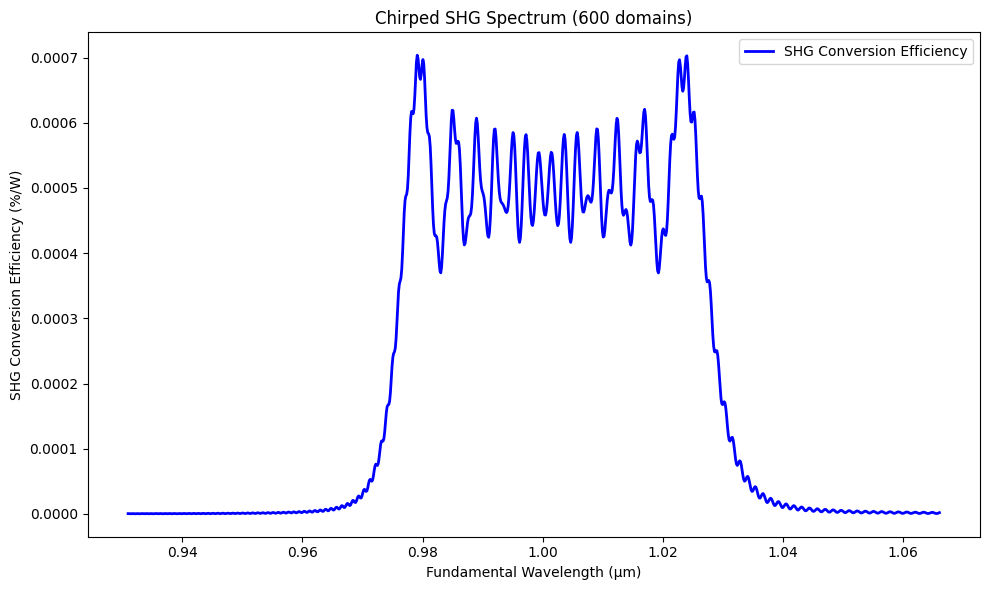

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap

from qpm import cwes, grating, mgoslt


def calc_dk_pairs(wls: jnp.ndarray, temp: float) -> jnp.ndarray:
    """Calculates phase mismatch pairs for given wavelengths."""
    delta_k1_values = mgoslt.calc_twm_delta_k(wls, wls, temp)
    delta_k2_values = mgoslt.calc_twm_delta_k(wls, wls / 2, temp)
    return jnp.stack([delta_k1_values, delta_k2_values], axis=1)


def compute_shg_spectrum(superlattice: jnp.ndarray, dk_pairs: jnp.ndarray) -> jnp.ndarray:
    """Computes the SHG spectrum by simulating each wavelength."""
    b_initial = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex64)

    def _simulate_single_point(dk_pair: jnp.ndarray) -> jnp.ndarray:
        """Simulates for a single delta_k pair and returns SHG efficiency."""
        b_final = cwes.simulate_twm(superlattice, dk_pair[0], dk_pair[1], b_initial)
        return jnp.abs(b_final[1]) ** 2

    # Vectorize and compile the simulation for performance.
    vmapped_simulation = vmap(_simulate_single_point)
    return jit(vmapped_simulation)(dk_pairs)


def main() -> None:
    """Main function to run the chirped SHG simulation and plot results."""
    # --- Parameters ---
    num_domains = 600
    initial_width = 3.6  # μm
    chirp_rate = 0.0001  # Chirp rate
    kappa_mag = 1.31e-5  # Nonlinear coupling coefficient magnitude
    temperature = 70.0  # Operating temperature (°C)
    wl_start, wl_end, num_points = 0.931, 1.066, 1000

    # --- Setup & Simulation ---
    print("1. Building grating and preparing simulation inputs...")
    profile = grating.tapered_profile(num_domains, initial_width, chirp_rate, kappa_mag)
    superlattice = grating.build(profile)
    wavelengths = jnp.linspace(wl_start, wl_end, num_points)
    dk_pairs = calc_dk_pairs(wavelengths, temperature)

    print("2. Running SHG simulation...")
    efficiencies = compute_shg_spectrum(superlattice, dk_pairs)

    # --- Plotting Results ---
    print("3. Plotting results...")
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, efficiencies * 100, "b-", linewidth=2, label="SHG Conversion Efficiency")
    plt.xlabel("Fundamental Wavelength (μm)")
    plt.ylabel("SHG Conversion Efficiency (%/W)")
    plt.title(f"Chirped SHG Spectrum ({num_domains} domains)")
    plt.legend()
    plt.tight_layout()
    plt.show()


main()